# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
DATA_FOLDER = "/home/vinz/Desktop/ADA/ADA2017-Tutorials/02 - Intro to Pandas/Data"

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average* per year of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

### Strategy

We will import and wrangle the data for each country separately and then combine everything into a single data frame.

As the data files already contain variables with nation wide statistics, we will use these values instead of manually aggregating the data city by city.

As specified on Mattermost, we track for both new cases and deaths the probable, suspected and confirmed values.

In [3]:
def ebola_csv_iter(folder):
    """Utility function returning an iterator over the csv files in given folder"""
    path = ''.join([DATA_FOLDER, '/ebola/', folder, '/'])
    for file in os.listdir(path):
        if file.endswith(".csv"):
            yield file, ''.join([path, file])

In [4]:
def associate_to_country(country, df):
    """Adds a country super index to the provided dataframe"""
    country = pd.DataFrame({
        'Country': np.repeat(country, len(df)),
        'Date': df.index
    })
    return country.merge(df, right_index=True, left_on='Date').set_index(['Country', 'Date'])

In [5]:
def parse_num(x):
    try:
        return np.float32(x)
    except ValueError:
        return np.nan

### Guinea

In [6]:
dfs = {}
tables_with_duplicates = []
interesting_fields = {
    #'New deaths registered today (confirmed)': 'Death confirmed',
    #'New deaths registered today (probables)': 'Death probable',
    #'New deaths registered today (suspects)': 'Death suspected',
    'Total deaths of suspects': 'Death suspected',
    'Total deaths of probables': 'Death probable',
    'Total deaths of confirmed': 'Death confirmed',
    'New cases of confirmed': 'New cases confirmed',
    'New cases of probables': 'New cases probable', 
    'New cases of suspects': 'New cases suspected'
}
for file, path in ebola_csv_iter('guinea_data'):
    df = pd.read_csv(path,
                     parse_dates=['Date'],
                     usecols=['Date', 'Description', 'Totals'],
                     converters={'Totals': parse_num})
    df.rename(columns={'Description': 'Variable', 'Totals': 'National'}, inplace=True)
    # Check for duplicates
    df = df[df.Variable.isin(interesting_fields)]
    if len(df.Variable.unique()) != len(df.Variable):
        tables_with_duplicates.append(file)
    dfs[file] = df

In [7]:
tables_with_duplicates

[]

As there are no duplicates, we can pivot all the dataframes to have a timeseries dataframe:

In [8]:
dfs = [df.pivot(index='Date', columns='Variable', values='National') for df in dfs.values()]

In [9]:
guinea = pd.concat(dfs).sort_index() # Create the data series: index=date
guinea = associate_to_country('Guinea', guinea).rename(columns=interesting_fields)

We started by using the fields:

 - `New deaths registered today (confirmed)`
 - `New deaths registered today (probables)`
 - `New deaths registered today (suspects)`
 
but they were empty for all days except one. Therefore we decided to use the cumulated values and perform the subtraction to obtain daily counts:

In [10]:
deaths = guinea[['Death confirmed', 'Death probable', 'Death suspected']]
cleaned = deaths - deaths.shift(1) # row_i - row_{i - 1}
guinea.loc[:, ['Death confirmed', 'Death probable', 'Death suspected']] = cleaned

This operation relies on a very important assumption. 
We repeat the same computation on the data concerning Liberia and Sierra Leone.
We assume that, given that the counts are cumulative, if we are missing a value for day $j$ and we have a value for day $i > j$, the value for day $j$ is counted in day $i$. **In other words, even if data for some days is missing, the totals are correct.**

In [11]:
guinea.head(n=10)

New cases confirmed  New cases probable  \
Country Date                                                  
Guinea  2014-08-04                  4.0                 0.0   
        2014-08-26                 10.0                 NaN   
        2014-08-27                 10.0                 0.0   
        2014-08-30                  9.0                 0.0   
        2014-08-31                 29.0                 8.0   
        2014-09-02                 14.0                 0.0   
        2014-09-04                 17.0                 0.0   
        2014-09-07                 11.0                 0.0   
        2014-09-08                 11.0                 0.0   
        2014-09-09                  7.0                 0.0   

                    New cases suspected  Death confirmed  Death probable  \
Country Date                                                               
Guinea  2014-08-04                  5.0              NaN             NaN   
        2014-08-26                 18.0             64.0             8.0   
        2014-08-27                 12.0              2.0             1.0   
        2014-08-30                 15.0             30.0             0.0   
        2014-08-31                  9.0             13.0             8.0   
        2014-09-02                 11.0             12.0             0.0   
        2014-09-04                 13.0             19.0             1.0   
        2014-09-07                  5.0             34.0             0.0   
        2014-09-08                  5.0              0.0             0.0   
        2014-09-09                  9.0              8.0             0.0   

                    Death suspected  
Country Date                         
Guinea  2014-08-04              NaN  
        2014-08-26              0.0  
        2014-08-27              0.0  
        2014-08-30              0.0  
        2014-08-31              0.0  
        2014-09-02              0.0  
        2014-09-04              1.0  
        2014-09-07              1.0  
        2014-09-08              0.0  
        2014-09-09              0.0

### Liberia

In [12]:
dfs = {}
tables_with_duplicates = []
interesting_fields = {
    'Total death/s in confirmed cases': 'Death confirmed',
    'Total death/s in probable cases': 'Death probable',
    'Total death/s in suspected cases': 'Death suspected',
    'New case/s (confirmed)': 'New cases confirmed',
    'New Case/s (Probable)': 'New cases probable',
    'New Case/s (Suspected)': 'New cases suspected'
}
for file, path in ebola_csv_iter('liberia_data'):
    df = pd.read_csv(path,
                     parse_dates=['Date'],
                     usecols=['Date', 'Variable', 'National'],
                     converters={'National': parse_num})
    df = df[df.Variable.isin(interesting_fields)]
    # Check for duplicates
    if len(df.Variable.unique()) != len(df.Variable):
        tables_with_duplicates.append(file)
    dfs[file] = df

We remark that only a data file contains duplicate variables for the same day. Before dropping the duplicates, we look at the duplicated lines:

In [13]:
tables_with_duplicates

['2014-10-04-v142.csv']

In [14]:
with_duplicates = dfs[tables_with_duplicates[0]]
with_duplicates[with_duplicates.duplicated(keep=False, subset='Variable')]

,Date,Variable,National
17,2014-10-04,Total death/s in confirmed cases,1012.0
18,2014-10-04,Total death/s in probable cases,699.0
19,2014-10-04,Total death/s in suspected cases,488.0
34,2014-10-04,Total death/s in confirmed cases,1018.0
35,2014-10-04,Total death/s in probable cases,701.0
36,2014-10-04,Total death/s in suspected cases,491.0


7 Variables are repeated twice.

In [15]:
first = with_duplicates[with_duplicates.duplicated(keep='last', subset='Variable')][['Variable', 'National']]
second = with_duplicates[with_duplicates.duplicated(keep='first', subset='Variable')][['Variable', 'National']]
first = first.set_index('Variable')
second = second.set_index('Variable')

In [16]:
second - first

,National
Variable,
Total death/s in confirmed cases,6.0
Total death/s in probable cases,2.0
Total death/s in suspected cases,3.0


We decided to keep the bigger values as the difference is not very relevant:

In [17]:
with_duplicates.drop_duplicates(subset='Variable', keep='last', inplace=True)

In [18]:
dfs = [df.pivot(index='Date', columns='Variable', values='National') for df in dfs.values()]

In [19]:
liberia = pd.concat(dfs).sort_index()
liberia = associate_to_country('Liberia', liberia).rename(columns=interesting_fields)

In [20]:
liberia.head(n=10)

New cases probable  New cases suspected  \
Country Date                                                  
Liberia 2014-06-16                 1.0                  2.0   
        2014-06-17                 0.0                  2.0   
        2014-06-22                 0.0                  5.0   
        2014-06-24                 0.0                  2.0   
        2014-06-25                 1.0                  4.0   
        2014-06-28                 6.0                  2.0   
        2014-06-29                 0.0                  0.0   
        2014-07-01                 0.0                  2.0   
        2014-07-02                 3.0                  1.0   
        2014-07-03                 2.0                  1.0   

                    New cases confirmed  Death confirmed  Death probable  \
Country Date                                                               
Liberia 2014-06-16                  1.0              8.0             6.0   
        2014-06-17                  0.0              8.0             6.0   
        2014-06-22                  5.0             16.0             8.0   
        2014-06-24                  4.0             18.0             8.0   
        2014-06-25                  2.0             20.0             8.0   
        2014-06-28                  1.0             26.0            10.0   
        2014-06-29                  2.0             26.0            10.0   
        2014-07-01                  2.0             30.0            17.0   
        2014-07-02                  0.0             32.0            20.0   
        2014-07-03                  1.0             33.0            22.0   

                    Death suspected  
Country Date                         
Liberia 2014-06-16              2.0  
        2014-06-17              2.0  
        2014-06-22              1.0  
        2014-06-24              6.0  
        2014-06-25              9.0  
        2014-06-28             13.0  
        2014-06-29             13.0  
        2014-07-01             14.0  
        2014-07-02             14.0  
        2014-07-03             15.0

However in this dataframe, the three deaths columns are *cumulative*. We can therefore subtract the value from the previous line.

In [21]:
deaths = liberia[['Death confirmed', 'Death probable', 'Death suspected']]
cleaned = deaths - deaths.shift(1) # row_i - row_{i - 1}
liberia.loc[:, ['Death confirmed', 'Death probable', 'Death suspected']] = cleaned

In [22]:
to_scale = liberia[-6:][['New cases probable', 'New cases suspected', 'New cases confirmed']]

In [23]:
liberia.loc[-6:, ['New cases probable', 'New cases suspected', 'New cases confirmed']] = to_scale - to_scale.shift(1)

### Sierra Leone

In [24]:
dfs = {}
tables_with_duplicates = []
interesting_fields = {
    'death_confirmed': 'Death confirmed',
    'death_probable': 'Death probable',
    'death_suspected': 'Death suspected',
    'new_confirmed': 'New cases confirmed',
    'new_probable': 'New cases probable',
    'new_suspected': 'New cases suspected'
}

for file, path in ebola_csv_iter('sl_data'):
    df = pd.read_csv(path,
                     parse_dates=['date'],
                     usecols=['date', 'variable', 'National'], 
                     converters={'National': parse_num})
    df.rename(columns={'date': 'Date', 'variable': 'Variable'}, inplace=True)
    df = df[df.Variable.isin(interesting_fields)]
    if len(df.Variable.unique()) != len(df.Variable):
        tables_with_duplicates.append(file)
    dfs[file] = df

In [25]:
tables_with_duplicates

[]

In [26]:
dfs = [df.pivot(index='Date', columns='Variable', values='National') for df in dfs.values()]

In [27]:
sl = pd.concat(dfs).sort_index()
sl = associate_to_country('Sierra Leone', sl).rename(columns=interesting_fields)

In [28]:
sl.head(n=10)

Death confirmed  Death probable  Death suspected  \
Country      Date                                                           
Sierra Leone 2014-08-12            264.0            34.0              5.0   
             2014-08-13            273.0            34.0              5.0   
             2014-08-14            280.0            34.0              5.0   
             2014-08-15            287.0            34.0              5.0   
             2014-08-16            297.0            34.0              5.0   
             2014-08-17            305.0            34.0              5.0   
             2014-08-18            312.0            34.0              5.0   
             2014-08-19            320.0            34.0              5.0   
             2014-08-20            322.0            34.0              5.0   
             2014-08-21            329.0            34.0              8.0   

                         New cases confirmed  New cases probable  \
Country      Date                                                  
Sierra Leone 2014-08-12                 11.0                 1.0   
             2014-08-13                 15.0                 1.0   
             2014-08-14                 13.0                 2.0   
             2014-08-15                 10.0                 1.0   
             2014-08-16                 18.0                 0.0   
             2014-08-17                  2.0                 0.0   
             2014-08-18                  5.0                15.0   
             2014-08-19                  9.0                 3.0   
             2014-08-20                  4.0                 0.0   
             2014-08-21                  9.0                 0.0   

                         New cases suspected  
Country      Date                             
Sierra Leone 2014-08-12                 10.0  
             2014-08-13                  3.0  
             2014-08-14                  0.0  
             2014-08-15                  6.0  
             2014-08-16                  3.0  
             2014-08-17                  1.0  
             2014-08-18                 40.0  
             2014-08-19                 16.0  
             2014-08-20                  1.0  
             2014-08-21                  0.0

The fields concerning the number of deaths are cumulative. We apply the same treatment as in the previous cases:

In [29]:
deaths = sl[['Death confirmed', 'Death probable', 'Death suspected']]
cleaned = deaths - deaths.shift(1) # row_i - row_{i - 1}
sl.loc[:, ['Death confirmed', 'Death probable', 'Death suspected']] = cleaned

In [30]:
del dfs
del tables_with_duplicates

### Combining the data

In [31]:
# Concatenate all dataframes
df = pd.concat([guinea, liberia, sl])

### Computing means

In [32]:
def month_average(group):
    # Only divide by the number of days counted in the set.
    registered_days = group.index.get_level_values(1).max().day
    return group.sum() / registered_days

In [33]:
import calendar
# Compute mean per month per country. 
results = df.groupby(lambda row: (row[0], row[1].month))\
            .agg(month_average)

# Give computation result a nice index
results.index = pd.MultiIndex.from_tuples(results.index, names=['Country', 'Month'])\
                  .map(lambda i: (i[0], calendar.month_name[i[1]]))

In [34]:
results

Death confirmed  Death probable  Death suspected  \
Guinea       August            3.516129        0.548387         0.000000   
             September         6.733333        0.833333         5.566667   
             October          23.000000        2.000000         0.000000   
Liberia      June              0.620690        0.137931         0.379310   
             July              1.538462        1.923077         0.230769   
             August            9.107143       10.357143         6.964286   
             September        18.266667        9.000000         7.100000   
             October           4.451613        1.548387         1.967742   
             November          0.000000        0.000000         0.000000   
             December          0.000000        0.000000         0.000000   
Sierra Leone August            3.096774        0.096774         0.096774   
             September         4.266667        0.000000         0.000000   
             October          16.774194        5.516129         4.709677   
             November         12.344828        0.000000         0.000000   
             December         16.307692        0.000000         0.000000   

                        New cases confirmed  New cases probable  \
Guinea       August                2.000000            0.258065   
             September             6.933333            0.633333   
             October               6.000000            0.000000   
Liberia      June                  0.517241            0.275862   
             July                  0.769231            1.576923   
             August                1.750000            6.357143   
             September             4.933333           23.466667   
             October               1.096774           14.322581   
             November              1.300000            3.500000   
             December              9.888889            2.222222   
Sierra Leone August               11.967742            0.741935   
             September            33.266667            0.000000   
             October              51.225806            0.774194   
             November             43.379310            0.000000   
             December             12.538462            0.000000   

                        New cases suspected  
Guinea       August                1.903226  
             September             2.900000  
             October              28.000000  
Liberia      June                  0.586207  
             July                  1.269231  
             August                3.857143  
             September            22.666667  
             October              21.322581  
             November              8.433333  
             December              4.333333  
Sierra Leone August                3.516129  
             September             6.066667  
             October              12.064516  
             November             11.103448  
             December              3.230769

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [35]:
# Setup for location of the dataset of the task 2
MICROBIOME_FOLDER = DATA_FOLDER + "/microbiome"


### Basic analysis of the file formatting:

***
**For the files MIDn.xls with n in [1,9]**

**column 1:**

We see that the first column in the files contain the scientific classification of the microbiomes
Altough it could be kept as a single string, it would have more meaning if splitted
The scientific classification contains the following subdivisions (https://en.wikipedia.org/wiki/Taxonomic_rank): 

       Domain, Kingdom, Phylum, Class, Order, Family, Genus, Species
       
 With this classification, we have a problem: only 6 strings are given in the data set, whilst we have 8 potential divisions in the classification.
 
 First, we note that in the scientific classification, Kingdom is not used with Bacterias (https://en.wikipedia.org/wiki/Bacteria) and in Archeas, it is always the same as the Phylum (https://en.wikipedia.org/wiki/Archaea). After checking the strings in the data set, it indeed seems that the Kingdom is never given. Therefore, **we will not use Kingdom as a division**.
 
 Also, Species only has a sense in the Eucaryote Domain, for which we have no data, so **we will not use Species as a division**.
 
 In addition, after playing with the data, we found cases where the Family can be named: "Incertae Sedis", which would be classified as the family and genus in our classification. Therefore, we need to check for those cases and re-concatenate the strings to return a proper list in every cases.

In [36]:
# Lets keep those names in a list for further use
scientific_classification = ["domain", "phylum", "class", "order", "family", "genus"]

**Column 2:**

We see that the second column contains an integer value. We can suppose that this value is the number of samples
containing the genus defined by the first column. There's no title to the column, so we don't know yet where
those values came from.

***

**For the file "Metadata.xls"**

**Column 1:**

Titled **"BARCODE"**, give xls file identifier for which the two other columns give more information

**Column 2:**

Titled **"GROUP"**, gives the groups from which each dataset has been sampled. Two informations are contained in those groups, the first is given by "NEC", "Control" or "EXTRACTION CONTROL" and the second is the numbering of the group (which is likely a phase of test), either "1" or "2". We will split those informations in two columns, because while using the dataset, we might want to combine all the "NEC" patients or all the patient for a specific phase.

**Column 3:**

Titled **"SAMPLE"**, gives the type of sample that was taken, either tissue, stool or NA. Each group had both types of samples taken. 

***

### Desired formating of the data after analysis

The simple analysis above tells us what are the columns that we will want in our Data Frame

1. **6** column for classification, 1 for each classifier in the "scientific_classification" list. This will caracterise each microbiome individually.

2. **1** column will contain the value associated with each microbiome measurement.

3. **2** columns describing the group of the sample from the metadata. The first column will be called **Group Type** and will contain the "NEC", "Control" or "EXTRACTION CONTROL" value. The second column will be called **Group Phase** and will contain either "1", "2" or "unknow", "unknow" will be used for the "EXCTRACTON CONTROL" group.

4. **1** column describing the type of sample taken from the metadata. This column will be called **Sample** This will be either "tissue", "stool" or "unknow", "unknow" in the case of the EXTRACTION CONTROL group.

For a total of **10** columns


In [37]:
metadata_list = ["group_type", "group_phase", "sample"]

In [38]:
df_col_list = scientific_classification + metadata_list + ["value"]

In [39]:
print(len(df_col_list))
print(df_col_list)

10
['domain', 'phylum', 'class', 'order', 'family', 'genus', 'group_type', 'group_phase', 'sample', 'value']


***
### We want to extract the metadata from the metadata.xls file

The metadata is needed before we start extracting the data from the MB files to create the DataFrame with all the desired columns.


In [40]:
#The actual name of the excel sheet is "Sheet1" and not "Sheet 1" as in the other files.
metadata_raw = pd.read_excel(MICROBIOME_FOLDER+"/metadata.xls", sheetname='Sheet1', header=0)
metadata_raw.columns = metadata_raw.columns.str.lower()

In [41]:
## Extract group phase and group type
groups = metadata_raw["group"]
group_type = []
group_phase = []
for group in groups:
    # A special case for the extraction control, we don't want to split it
    if group == "EXTRACTION CONTROL":
        group_type.append(group)
        group_phase.append("")
    else:
        type, phase, *_ = group.split()
        group_type.append(type)
        group_phase.append(phase)

In [42]:
metadata_raw['group_type'] = pd.Series(group_type)
metadata_raw['group_phase'] = pd.Series(group_phase)
metadata = metadata_raw.drop("group",  axis=1)
metadata

,barcode,sample,group_type,group_phase
0,MID1,NaN,EXTRACTION CONTROL,
1,MID2,tissue,NEC,1
2,MID3,tissue,Control,1
3,MID4,tissue,NEC,2
4,MID5,tissue,Control,2
5,MID6,stool,NEC,1
6,MID7,stool,Control,1
7,MID8,stool,NEC,2
8,MID9,stool,Control,2


In [43]:
# Make sure SAMPLE doesn't contain NaN, replace it by an empty string
# This will give use prettier column names later on
metadata["sample"].fillna(value="", inplace=True)
metadata

,barcode,sample,group_type,group_phase
0,MID1,,EXTRACTION CONTROL,
1,MID2,tissue,NEC,1
2,MID3,tissue,Control,1
3,MID4,tissue,NEC,2
4,MID5,tissue,Control,2
5,MID6,stool,NEC,1
6,MID7,stool,Control,1
7,MID8,stool,NEC,2
8,MID9,stool,Control,2


The format of the metadata is now as we want it

***
### We now want to extract the data from the datasheets

** We create a function to extract the classifications **

We want to extract the classifications from the first column of the datasheets. We will need to do string parsing. Regex are a great tool to remove the unwanted characters from the format. The only unwanted characters are the double quotes ". Also, as said before, we need to manage the case where we have the name "Incertae Sedis" as a Family (4th position)

In [44]:
import re

def get_classifiers(classifier_string):
    """Replaces " in the classifier_string and 
    splits the string to have an indexable list
    """
    classified_list = re.subn("\"", "", classifier_string)[0].lower().split()
    
    # Special case management
    if len(classified_list) > 6:
        # We join the first extra location with the family
        classified_list[4] = ' '.join([classified_list[4], classified_list[5]])
        del classified_list[5]
        
        # Allow for harbitrary number of words in the genus
        classified_list[5] = ' '.join(classified_list[6:])
        del classified_list[6:]
        
    return classified_list

** We can now attempt to create the desired dataframe **

In [45]:
# In this section, we test the analysis of a single datasheet
test_data = pd.read_excel(MICROBIOME_FOLDER+"/MID1.xls", sheetname='Sheet 1', header=None)
test_data.columns = ["raw_classification", "value"]
classifier_df = pd.DataFrame(columns=df_col_list)
classifier_array = [get_classifiers(row.raw_classification) for row in test_data.itertuples()]
classifier_series = pd.DataFrame(classifier_array, columns=scientific_classification)
classifier_series["value"] = test_data["value"]
classifier_series

,domain,phylum,class,order,family,genus,value
0,archaea,crenarchaeota,thermoprotei,desulfurococcales,desulfurococcaceae,ignisphaera,7
1,archaea,crenarchaeota,thermoprotei,desulfurococcales,pyrodictiaceae,pyrolobus,2
2,archaea,crenarchaeota,thermoprotei,sulfolobales,sulfolobaceae,stygiolobus,3
3,archaea,crenarchaeota,thermoprotei,thermoproteales,thermofilaceae,thermofilum,3
4,archaea,euryarchaeota,methanomicrobia,methanocellales,methanocellaceae,methanocella,7
5,archaea,euryarchaeota,methanomicrobia,methanosarcinales,methanosarcinaceae,methanimicrococcus,1
6,archaea,euryarchaeota,methanomicrobia,methanosarcinales,methermicoccaceae,methermicoccus,1
7,archaea,euryarchaeota,archaeoglobi,archaeoglobales,archaeoglobaceae,ferroglobus,1
8,archaea,euryarchaeota,archaeoglobi,archaeoglobales,archaeoglobaceae,geoglobus,1
9,archaea,euryarchaeota,halobacteria,halobacteriales,halobacteriaceae,haloplanus,1


In [46]:
# We reorder the metadata here, this will order the resulting data
metadata = metadata[["barcode", "group_phase", "group_type", "sample"]]\
              .sort_values(by=[ 'group_phase', 'group_type', 'sample'])
metadata.head(10)

,barcode,group_phase,group_type,sample
0,MID1,,EXTRACTION CONTROL,
6,MID7,1,Control,stool
2,MID3,1,Control,tissue
5,MID6,1,NEC,stool
1,MID2,1,NEC,tissue
8,MID9,2,Control,stool
4,MID5,2,Control,tissue
7,MID8,2,NEC,stool
3,MID4,2,NEC,tissue


In [47]:
# Loop over all the datasheets
clean_data = pd.DataFrame(columns=scientific_classification)
for metadata_row in metadata.itertuples():
    raw_data = pd.read_excel(MICROBIOME_FOLDER+"/"+metadata_row.barcode+".xls", sheetname='Sheet 1', header=None)
    # Change column names to something clearer
    raw_data.columns = ["raw_classification", "value"]
    
    # For each datasheet create a local classified set of data
    classifier_array = [get_classifiers(row.raw_classification) for row in raw_data.itertuples()]
    local_classified = pd.DataFrame(classifier_array, columns=scientific_classification)
    
    # Add the columns that are not the classification to the local set of data 
    local_classified[str(metadata_row.barcode)]  = test_data["value"]
    # Add the local data to the clean DataFrame
    clean_data = pd.merge(clean_data, local_classified, how="outer", on=scientific_classification)

clean_data.head(10)

,domain,phylum,class,order,family,genus,MID1,MID7,MID3,MID6,MID2,MID9,MID5,MID8,MID4
0,archaea,crenarchaeota,thermoprotei,desulfurococcales,desulfurococcaceae,ignisphaera,7.0,2.0,3.0,7.0,3.0,2.0,3.0,NaN,7.0
1,archaea,crenarchaeota,thermoprotei,desulfurococcales,pyrodictiaceae,pyrolobus,2.0,1.0,NaN,3.0,1.0,NaN,1.0,NaN,NaN
2,archaea,crenarchaeota,thermoprotei,sulfolobales,sulfolobaceae,stygiolobus,3.0,1.0,1.0,7.0,1.0,7.0,1.0,7.0,NaN
3,archaea,crenarchaeota,thermoprotei,thermoproteales,thermofilaceae,thermofilum,3.0,1.0,1.0,1.0,1.0,1.0,4.0,NaN,NaN
4,archaea,euryarchaeota,methanomicrobia,methanocellales,methanocellaceae,methanocella,7.0,1.0,2.0,1.0,2.0,1.0,4.0,NaN,3.0
5,archaea,euryarchaeota,methanomicrobia,methanosarcinales,methanosarcinaceae,methanimicrococcus,1.0,2.0,12.0,4.0,1.0,2.0,2.0,NaN,NaN
6,archaea,euryarchaeota,methanomicrobia,methanosarcinales,methermicoccaceae,methermicoccus,1.0,4.0,2.0,2.0,12.0,4.0,1.0,NaN,NaN
7,archaea,euryarchaeota,archaeoglobi,archaeoglobales,archaeoglobaceae,ferroglobus,1.0,1.0,NaN,4.0,2.0,1.0,1.0,NaN,3.0
8,archaea,euryarchaeota,archaeoglobi,archaeoglobales,archaeoglobaceae,geoglobus,1.0,12.0,NaN,NaN,NaN,12.0,1.0,NaN,NaN
9,archaea,euryarchaeota,halobacteria,halobacteriales,halobacteriaceae,haloplanus,1.0,2.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN


** Lets find all rows that contains only NaN values **

Those rows are not usefull for the analysis and we will drop them.

In [48]:
# Get a table with True in place of a row where all the MID values are null
table_of_null_row = pd.isnull(clean_data[metadata.barcode]).all(axis=1)

# Get the associated indexes
index_of_null_row = table_of_null_row[table_of_null_row].index[:]

# Lets check that the value are actually null
clean_data.iloc[index_of_null_row]

,domain,phylum,class,order,family,genus,MID1,MID7,MID3,MID6,MID2,MID9,MID5,MID8,MID4
419,bacteria,proteobacteria,betaproteobacteria,burkholderiales,comamonadaceae,rhodoferax,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
420,bacteria,proteobacteria,betaproteobacteria,burkholderiales,comamonadaceae,simplicispira,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421,bacteria,proteobacteria,betaproteobacteria,burkholderiales,comamonadaceae,tepidicella,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422,bacteria,proteobacteria,betaproteobacteria,burkholderiales,oxalobacteraceae,undibacterium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
423,bacteria,proteobacteria,betaproteobacteria,hydrogenophilales,hydrogenophilaceae,tepidiphilus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
425,bacteria,proteobacteria,betaproteobacteria,methylophilales,methylophilaceae,methylovorus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
426,bacteria,proteobacteria,betaproteobacteria,neisseriales,neisseriaceae,formivibrio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
427,bacteria,proteobacteria,betaproteobacteria,neisseriales,neisseriaceae,leeia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
428,bacteria,proteobacteria,betaproteobacteria,neisseriales,neisseriaceae,microvirgula,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
430,bacteria,proteobacteria,betaproteobacteria,neisseriales,neisseriaceae,stenoxybacter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
clean_data = clean_data.drop(index_of_null_row)

** Now lets replace all the None values by unknow **

In [50]:
clean_data.fillna(value="unknown", inplace=True)

In [51]:
clean_data.head(n=5)

,domain,phylum,class,order,family,genus,MID1,MID7,MID3,MID6,MID2,MID9,MID5,MID8,MID4
0,archaea,crenarchaeota,thermoprotei,desulfurococcales,desulfurococcaceae,ignisphaera,7,2,3,7,3,2,3,unknown,7
1,archaea,crenarchaeota,thermoprotei,desulfurococcales,pyrodictiaceae,pyrolobus,2,1,unknown,3,1,unknown,1,unknown,unknown
2,archaea,crenarchaeota,thermoprotei,sulfolobales,sulfolobaceae,stygiolobus,3,1,1,7,1,7,1,7,unknown
3,archaea,crenarchaeota,thermoprotei,thermoproteales,thermofilaceae,thermofilum,3,1,1,1,1,1,4,unknown,unknown
4,archaea,euryarchaeota,methanomicrobia,methanocellales,methanocellaceae,methanocella,7,1,2,1,2,1,4,unknown,3


We see that some genus are unknown... This seems a bit odd, so we will search if one other of the term is the actual genus

In [52]:
unknown_genus = clean_data[clean_data.genus == 'unknown']
unknown_genus

,domain,phylum,class,order,family,genus,MID1,MID7,MID3,MID6,MID2,MID9,MID5,MID8,MID4
148,bacteria,proteobacteria,alphaproteobacteria,alphaproteobacteria_incertae_sedis,elioraea,unknown,1,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
223,bacteria,proteobacteria,gammaproteobacteria,gammaproteobacteria_incertae_sedis,gilvimarinus,unknown,1,unknown,unknown,1,unknown,2,unknown,unknown,unknown
224,bacteria,proteobacteria,gammaproteobacteria,gammaproteobacteria_incertae_sedis,solimonas,unknown,2,unknown,unknown,unknown,unknown,162,unknown,unknown,unknown
269,bacteria,cyanobacteria,cyanobacteria,chloroplast,bangiophyceae,unknown,2,unknown,unknown,unknown,unknown,unknown,unknown,196,unknown
270,bacteria,cyanobacteria,cyanobacteria,chloroplast,chlorarachniophyceae,unknown,85,unknown,unknown,unknown,unknown,unknown,unknown,1,1
271,bacteria,cyanobacteria,cyanobacteria,chloroplast,streptophyta,unknown,1388,unknown,unknown,unknown,unknown,unknown,unknown,unknown,1
281,bacteria,actinobacteria,actinobacteria,acidimicrobidae_incertae_sedis,ilumatobacter,unknown,unknown,3,2,unknown,unknown,unknown,1,unknown,unknown
384,bacteria,proteobacteria,alphaproteobacteria,alphaproteobacteria_incertae_sedis,geminicoccus,unknown,unknown,1,unknown,unknown,unknown,unknown,unknown,unknown,unknown
455,bacteria,proteobacteria,gammaproteobacteria,gammaproteobacteria_incertae_sedis,sedimenticola,unknown,unknown,unknown,unknown,unknown,unknown,9,unknown,unknown,unknown
512,bacteria,bacteroidetes,bacteroidetes_incertae_sedis,marinifilum,unknown,unknown,unknown,unknown,1,unknown,unknown,unknown,unknown,7,12


From the list above, we can see that we have many cases where we have a string containing "incertae_sedis". Normally, this nomenclature is used when a genus doesn't have clear parents (https://en.wikipedia.org/wiki/Incertae_sedis). Because of this we will attempt to use the first class after the incertae_sedis as the name of the genus and keep the other values as unknown.

In the case of "(some term)_genera_incertae_sedis", it means that the term is the genus and the rest is unknown, so we will do a special parse for those cases.

In cases where we don't have incertae sedis, we will avoid doing manipulations. We don't want to induce errors in the dataset because we managed poorly the nomenclature for the specific cases. Because there's a small amount of thoses cases left after the analysis, it could be asked to an expert in the domain or obtained with more advanced research on the subject to add a case by case filter

In [53]:
def get_incertae_genus(class_, order):
    """Extracts genus from either class or order if either of them contain incertae_sedis"""
    for target in [class_, order]:
        genus, *rest = target.split('_incertae_sedis')
        if len(rest) > 0:
            return genus
    return 'unknown'

In [54]:
genuses = [get_incertae_genus(c, o) for *_, c, o in unknown_genus[['class', 'order']].itertuples()]

In [55]:
# Insert newly retrieved genus names
clean_data.loc[clean_data.genus == 'unknown', 'genus'] = genuses

In [56]:
# Find the remaining unknown genus, those will not be managed and would be left for later manual management
clean_data[clean_data.genus == 'unknown']

,domain,phylum,class,order,family,genus,MID1,MID7,MID3,MID6,MID2,MID9,MID5,MID8,MID4
269,bacteria,cyanobacteria,cyanobacteria,chloroplast,bangiophyceae,unknown,2,unknown,unknown,unknown,unknown,unknown,unknown,196,unknown
270,bacteria,cyanobacteria,cyanobacteria,chloroplast,chlorarachniophyceae,unknown,85,unknown,unknown,unknown,unknown,unknown,unknown,1,1
271,bacteria,cyanobacteria,cyanobacteria,chloroplast,streptophyta,unknown,1388,unknown,unknown,unknown,unknown,unknown,unknown,unknown,1
677,bacteria,chloroflexi,dehalococcoidetes,dehalogenimonas,unknown,unknown,unknown,unknown,unknown,unknown,unknown,6,1,unknown,unknown
712,bacteria,acidobacteria,acidobacteria_gp16,gp16,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,17,unknown,unknown


**Replace the incertae sedis by unknown**

In the cases where we have incertae sedis in one of the column, we will replace the value incertae_sedis by unknown. It keeps the actual information because we already setted the associated genus in the previous step. This will allow for a cleaner overall dataset

In [57]:
def print_all_incertae_sedis(data_frame):
    """ This function extract all the incertae sedis from the class, order and family of a dataframe"""
    print("Found incertae sedis in:")
    for i, c, o, f in clean_data[["class", "order", "family"]].itertuples():
        if "_incertae_sedis" in c or "incertae sedis" in c:
            print("Class '", c, "' at index ", i)
        elif "_incertae_sedis" in o or "incertae sedis" in o:
            print("Order '", o, "' at index ", i)
        elif "_incertae_sedis" in f or "incertae sedis" in f:
            print("Family '", f, "' at index ", i)    

In [58]:
# Show that there's incertae sedis in the data frame "clean_data"
print_all_incertae_sedis(clean_data)

Found incertae sedis in:
Family ' thermoplasmatales_incertae_sedis ' at index  16
Family ' frankineae_incertae_sedis ' at index  26
Family ' incertae sedis ' at index  124
Family ' incertae sedis ' at index  125
Family ' incertae sedis ' at index  126
Family ' incertae sedis ' at index  127
Family ' incertae sedis ' at index  128
Order ' alphaproteobacteria_incertae_sedis ' at index  148
Family ' burkholderiales_incertae_sedis ' at index  177
Family ' burkholderiales_incertae_sedis ' at index  178
Family ' burkholderiales_incertae_sedis ' at index  179
Family ' burkholderiales_incertae_sedis ' at index  180
Family ' burkholderiales_incertae_sedis ' at index  181
Family ' burkholderiales_incertae_sedis ' at index  182
Family ' burkholderiales_incertae_sedis ' at index  183
Family ' burkholderiales_incertae_sedis ' at index  184
Order ' gammaproteobacteria_incertae_sedis ' at index  223
Order ' gammaproteobacteria_incertae_sedis ' at index  224
Family ' thiotrichales_incertae_sedis ' at 

In [59]:
# Use the panda library to find all incertae sedis in the data set and replace it by unknown
for column in clean_data.columns:
    clean_data[column].replace(to_replace=".*incertae[_ ]sedis",
                               value="unknown",
                               inplace=True,
                               regex=True)    

In [60]:
print_all_incertae_sedis(clean_data)

Found incertae sedis in:


** Now lets manage the index of the DataFrame **

For now, we consider that every column but the value can be considered as a metadata. 

In [61]:
indexed_data = clean_data.set_index(list(scientific_classification))
indexed_data.head(5)

MID1  \
domain  phylum        class           order             family             genus               
archaea crenarchaeota thermoprotei    desulfurococcales desulfurococcaceae ignisphaera     7   
                                                        pyrodictiaceae     pyrolobus       2   
                                      sulfolobales      sulfolobaceae      stygiolobus     3   
                                      thermoproteales   thermofilaceae     thermofilum     3   
        euryarchaeota methanomicrobia methanocellales   methanocellaceae   methanocella    7   

                                                                                        MID7  \
domain  phylum        class           order             family             genus               
archaea crenarchaeota thermoprotei    desulfurococcales desulfurococcaceae ignisphaera     2   
                                                        pyrodictiaceae     pyrolobus       1   
                                      sulfolobales      sulfolobaceae      stygiolobus     1   
                                      thermoproteales   thermofilaceae     thermofilum     1   
        euryarchaeota methanomicrobia methanocellales   methanocellaceae   methanocella    1   

                                                                                            MID3  \
domain  phylum        class           order             family             genus                   
archaea crenarchaeota thermoprotei    desulfurococcales desulfurococcaceae ignisphaera         3   
                                                        pyrodictiaceae     pyrolobus     unknown   
                                      sulfolobales      sulfolobaceae      stygiolobus         1   
                                      thermoproteales   thermofilaceae     thermofilum         1   
        euryarchaeota methanomicrobia methanocellales   methanocellaceae   methanocella        2   

                                                                                        MID6  \
domain  phylum        class           order             family             genus               
archaea crenarchaeota thermoprotei    desulfurococcales desulfurococcaceae ignisphaera     7   
                                                        pyrodictiaceae     pyrolobus       3   
                                      sulfolobales      sulfolobaceae      stygiolobus     7   
                                      thermoproteales   thermofilaceae     thermofilum     1   
        euryarchaeota methanomicrobia methanocellales   methanocellaceae   methanocella    1   

                                                                                        MID2  \
domain  phylum        class           order             family             genus               
archaea crenarchaeota thermoprotei    desulfurococcales desulfurococcaceae ignisphaera     3   
                                                        pyrodictiaceae     pyrolobus       1   
                                      sulfolobales      sulfolobaceae      stygiolobus     1   
                                      thermoproteales   thermofilaceae     thermofilum     1   
        euryarchaeota methanomicrobia methanocellales   methanocellaceae   methanocella    2   

                                                                                            MID9  \
domain  phylum        class           order             family             genus                   
archaea crenarchaeota thermoprotei    desulfurococcales desulfurococcaceae ignisphaera         2   
                                                        pyrodictiaceae     pyrolobus     unknown   
                                      sulfolobales      sulfolobaceae      stygiolobus         7   
                                      thermoproteales   thermofilaceae     thermofilum         1   
        euryarchaeota methanomicrobia methanocellales   methanocellaceae   methanocella        

In [62]:
indexed_data.index.is_unique

True

** Now lets give the column to more meaningfull names **

The ordering of the columns is already managed to give a nice output. This is why we reordered the metadata earlier on.

In [63]:
pretty_data = pd.DataFrame(data=indexed_data.values,
                           index=indexed_data.index,
                           columns=[metadata.group_phase.get_values(),
                                    metadata.group_type.get_values(),
                                    metadata["sample"].get_values()])
pretty_data.head(5)

\
                                                                                        EXTRACTION CONTROL   
                                                                                                             
domain  phylum        class           order             family             genus                             
archaea crenarchaeota thermoprotei    desulfurococcales desulfurococcaceae ignisphaera                   7   
                                                        pyrodictiaceae     pyrolobus                     2   
                                      sulfolobales      sulfolobaceae      stygiolobus                   3   
                                      thermoproteales   thermofilaceae     thermofilum                   3   
        euryarchaeota methanomicrobia methanocellales   methanocellaceae   methanocella                  7   

                                                                                              1  \
                                                                                        Control   
                                                                                          stool   
domain  phylum        class           order             family             genus                  
archaea crenarchaeota thermoprotei    desulfurococcales desulfurococcaceae ignisphaera        2   
                                                        pyrodictiaceae     pyrolobus          1   
                                      sulfolobales      sulfolobaceae      stygiolobus        1   
                                      thermoproteales   thermofilaceae     thermofilum        1   
        euryarchaeota methanomicrobia methanocellales   methanocellaceae   methanocella       1   

                                                                                                  \
                                                                                                   
                                                                                          tissue   
domain  phylum        class           order             family             genus                   
archaea crenarchaeota thermoprotei    desulfurococcales desulfurococcaceae ignisphaera         3   
                                                        pyrodictiaceae     pyrolobus     unknown   
                                      sulfolobales      sulfolobaceae      stygiolobus         1   
                                      thermoproteales   thermofilaceae     thermofilum         1   
        euryarchaeota methanomicrobia methanocellales   methanocellaceae   methanocella        2   

                                                                                               \
                                                                                          NEC   
                                                                                        stool   
domain  phylum        class           order             family             genus                
archaea crenarchaeota thermoprotei    desulfurococcales desulfurococcaceae ignisphaera      7   
                                                        pyrodictiaceae     pyrolobus        3   
                                      sulfolobales      sulfolobaceae      stygiolobus      7   
                                      thermoproteales   thermofilaceae     thermofilum      1   
        euryarchaeota methanomicrobia methanocellales   methanocellaceae   methanocella     1   

                                                                                                \
                                                                                                 
                                                                                        tissue   
domain  phylum        class           order             family             genus                 
archaea crenarchaeota thermoprotei    desulfurococcales de

In [64]:
#Lets give a name to the columns
pretty_data.columns.names = ["Group Number", "Group Type", "Sample"]
pretty_data.head(10)

Group Number                                                                                                      \
Group Type                                                                                    EXTRACTION CONTROL   
Sample                                                                                                             
domain  phylum        class           order             family             genus                                   
archaea crenarchaeota thermoprotei    desulfurococcales desulfurococcaceae ignisphaera                         7   
                                                        pyrodictiaceae     pyrolobus                           2   
                                      sulfolobales      sulfolobaceae      stygiolobus                         3   
                                      thermoproteales   thermofilaceae     thermofilum                         3   
        euryarchaeota methanomicrobia methanocellales   methanocellaceae   methanocella                        7   
                                      methanosarcinales methanosarcinaceae methanimicrococcus                  1   
                                                        methermicoccaceae  methermicoccus                      1   
                      archaeoglobi    archaeoglobales   archaeoglobaceae   ferroglobus                         1   
                                                                           geoglobus                           1   
                      halobacteria    halobacteriales   halobacteriaceae   haloplanus                          1   

Group Number                                                                                        1  \
Group Type                                                                                    Control   
Sample                                                                                          stool   
domain  phylum        class           order             family             genus                        
archaea crenarchaeota thermoprotei    desulfurococcales desulfurococcaceae ignisphaera              2   
                                                        pyrodictiaceae     pyrolobus                1   
                                      sulfolobales      sulfolobaceae      stygiolobus              1   
                                      thermoproteales   thermofilaceae     thermofilum              1   
        euryarchaeota methanomicrobia methanocellales   methanocellaceae   methanocella             1   
                                      methanosarcinales methanosarcinaceae methanimicrococcus       2   
                                                        methermicoccaceae  methermicoccus           4   
                      archaeoglobi    archaeoglobales   archaeoglobaceae   ferroglobus              1   
                                                                           geoglobus               12   
                      halobacteria    halobacteriales   halobacteriaceae   haloplanus               2   

Group Number                                                                                            \
Group Type                                                                                               
Sample                                                                                          tissue   
domain  phylum        class           order             family             genus                         
archaea crenarchaeota thermoprotei    desulfurococcales desulfurococcaceae ignisphaera               3   
                                                        pyrodictiaceae     pyrolobus           unknown   
                                      sulfolobales      sulfolobaceae      stygiolobus               1   
                                      thermoproteales   thermofilaceae     thermofilum               1   
        euryarchaeota methanomicrobia methanocellales   

In [65]:
# Lets export the resulting data for easy referencing
pretty_data.to_csv("resulting_data.csv")

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [66]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

### Question 1

We define the types of the attributes we will use in this task and then load the dataset in titanic.xls

In [67]:
columns_types = {
    'pclass': np.uint8,
    'survived': np.bool_,
    'parch': np.uint8,
    'sibsp': np.uint8,
    'age': np.float32,
    'fare': np.float32,
}

titanic = pd.read_excel(DATA_FOLDER + '/titanic.xls',
                        dtype=columns_types)

We transform the attributes pclass, sex and embarked into Categorical. It makes sense to do it with those attributes as the range of values is not very large and it will be useful in the future to display the bar plots.

We then rename the categories to make them easier to understand and visualize

In [68]:
titanic.pclass = titanic.pclass.astype('category')
titanic.sex = titanic.sex.astype('category')
titanic.embarked = titanic.embarked.astype('category')

In [69]:
titanic.pclass.cat.rename_categories(['First', 'Second', 'Third'], inplace=True)
titanic.sex.cat.rename_categories(['Female', 'Male'], inplace=True)
titanic.embarked.cat.rename_categories(['Cherbourg', 'Queenstown', 'Southampton'], inplace=True)

In [70]:
titanic.head(n=10)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,First,True,"Allen, Miss. Elisabeth Walton",Female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,First,True,"Allison, Master. Hudson Trevor",Male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,First,False,"Allison, Miss. Helen Loraine",Female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,First,False,"Allison, Mr. Hudson Joshua Creighton",Male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,First,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",Female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,First,True,"Anderson, Mr. Harry",Male,48.0000,0,0,19952,26.549999,E12,Southampton,3,NaN,"New York, NY"
6,First,True,"Andrews, Miss. Kornelia Theodosia",Female,63.0000,1,0,13502,77.958298,D7,Southampton,10,NaN,"Hudson, NY"
7,First,False,"Andrews, Mr. Thomas Jr",Male,39.0000,0,0,112050,0.000000,A36,Southampton,NaN,NaN,"Belfast, NI"
8,First,True,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",Female,53.0000,2,0,11769,51.479198,C101,Southampton,D,NaN,"Bayside, Queens, NY"
9,First,False,"Artagaveytia, Mr. Ramon",Male,71.0000,0,0,PC 17609,49.504200,NaN,Cherbourg,NaN,22.0,"Montevideo, Uruguay"


We display the type of each attribute and in the cell below the value range

In [71]:
titanic.dtypes

pclass       category
survived         bool
name           object
sex          category
age           float32
sibsp           uint8
parch           uint8
ticket         object
fare          float32
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

In [72]:
# Describe range of numeric variables
titanic[['age', 'sibsp', 'parch', 'fare']].describe().transpose()[['min', 'max']]

,min,max
age,0.1667,80.000000
sibsp,0.0000,8.000000
parch,0.0000,9.000000
fare,0.0000,512.329224


### Question 2

We first plot the histograms for the travel class, embarkation port and sex attributes

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt

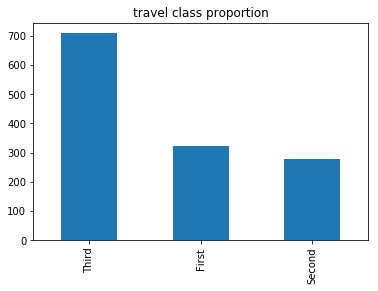

In [74]:
titanic.pclass.value_counts().plot(kind='bar')
plt.title('travel class proportion')

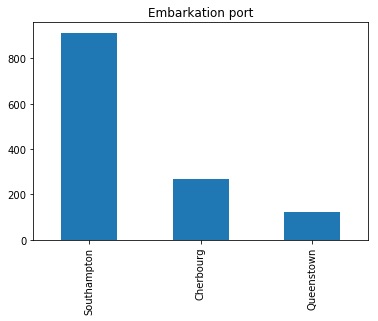

In [75]:
titanic.embarked.value_counts().plot(kind='bar')
plt.title('Embarkation port')

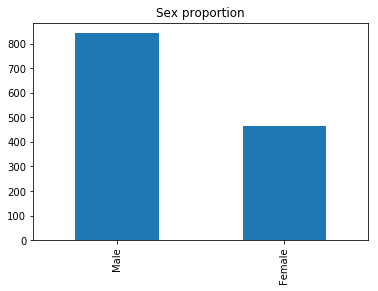

In [76]:
titanic.sex.value_counts().plot(kind='bar')
plt.title('Sex proportion')

For this histogram we use discrete decade intervals from 0 to 80 (maximum age)

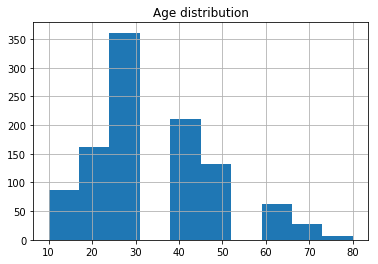

In [77]:
pd.cut(titanic.age, [0, 10, 20, 30, 40, 50, 60, 70, 80], labels=[10, 20, 30, 40, 50, 60, 70, 80]).hist()
plt.title('Age distribution')

### Question 3

We are looking for the proportion of passengers by cabin floor. We thus copy the cabin attribute to drop the NAN without altering the original one. We copy/modify it in a way such that we just keep the letter of the cabin floor.

In [78]:
floor_counts = titanic.cabin.copy()\
                            .str.extract('([A-Z])')\
                            .dropna()\
                            .value_counts()

/home/vinz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


We then present the results in a pie chart with the different letters of the cabin floors

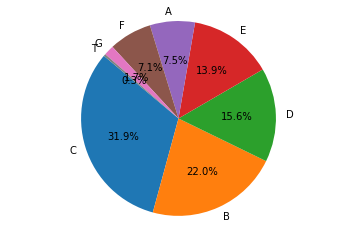

In [79]:
plt.pie(floor_counts, labels=floor_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.show()

### Question 4

In this question we will present our results in three pie charts : one for each travel class representing the proportion of the passengers that survived.

So first of all we group the entries by pclass and compute for each pclass the mean of survived people. Which gives us the proportion if survived passengers

In [80]:
survived = titanic[['pclass', 'survived']].groupby('pclass')\
                                          .mean()

In [81]:
survived

,survived
pclass,
First,0.619195
Second,0.429603
Third,0.255289


We know plot a pie chart for each class

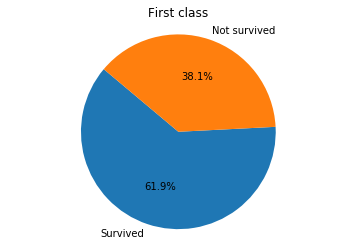

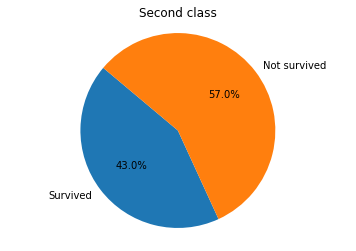

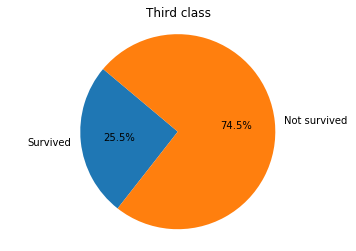

In [82]:
labels = 'Survived', 'Not survived'

for class_ in titanic.pclass.cat.categories:
    ratios = survived['survived'][class_], 1 - survived['survived'][class_]
    plt.pie(ratios, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(' '.join([class_, 'class']))
    plt.show()

### Question 5

Here we want to represent the proportion of passengers that survived by travel class and sex.
To implement it we set the index (a multi index) of the titanic dataframe to (pclass, sex).
Thus we will be able to represent the "survival rate" in function of this index by grouping pclass and sex and applying the mean to the survived column

In [83]:
survival_rates_class_sex = titanic.set_index(['pclass','sex'])\
                                  .groupby(level=('pclass','sex'),axis=0)[['survived']]\
                                  .mean()

In [84]:
survival_rates_class_sex

survived
pclass sex             
First  Female  0.965278
       Male    0.340782
Second Female  0.886792
       Male    0.146199
Third  Female  0.490741
       Male    0.152130

We know represent our results in a single histogram

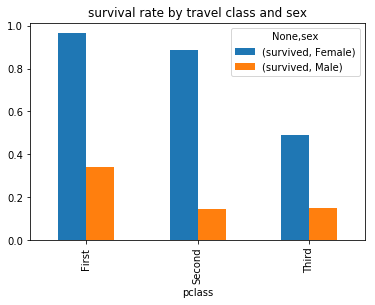

In [85]:
survival_rates_class_sex.unstack().plot.bar()
plt.title('survival rate by travel class and sex')

### Question 6

In this question we will work on ages. We first decide to drop all the NaN in the column of ages. Then we will create the two categories of ages

In [86]:
titanic2 = titanic.dropna(subset=['age']).copy()

To create the two age categories, we decide to use the median of all the ages which seems to be the best way of dividing the set. Hence we create the two categories "young" and "old" containing respectively the values [0, median] and [median+1, max]

In [87]:
titanic_ages = pd.cut(titanic.age, [0, titanic2.age.median(), titanic2.age.max()], labels=['young','old'])
titanic2['age'] = titanic_ages

We now groupby the dataframe with pclass, sex and age as they are the attributes we are interested in and compute the mean of 'survived' values for those groups.

In [88]:
result = titanic2.groupby(('pclass','sex','age'),axis=0)[['survived']]\
                 .mean()\
                 .round(3)\
                 .unstack('age')

In [89]:
result

survived       
age                old  young
pclass sex                   
First  Female    0.967  0.951
       Male      0.303  0.531
Second Female    0.872  0.911
       Male      0.083  0.216
Third  Female    0.372  0.514
       Male      0.144  0.183

We now check that the index of our dataframe is unique

In [90]:
result.index.is_unique

True